# Better identification

In [1]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

## Reference design and training & testing datasets generation

(2, 1000, 1)


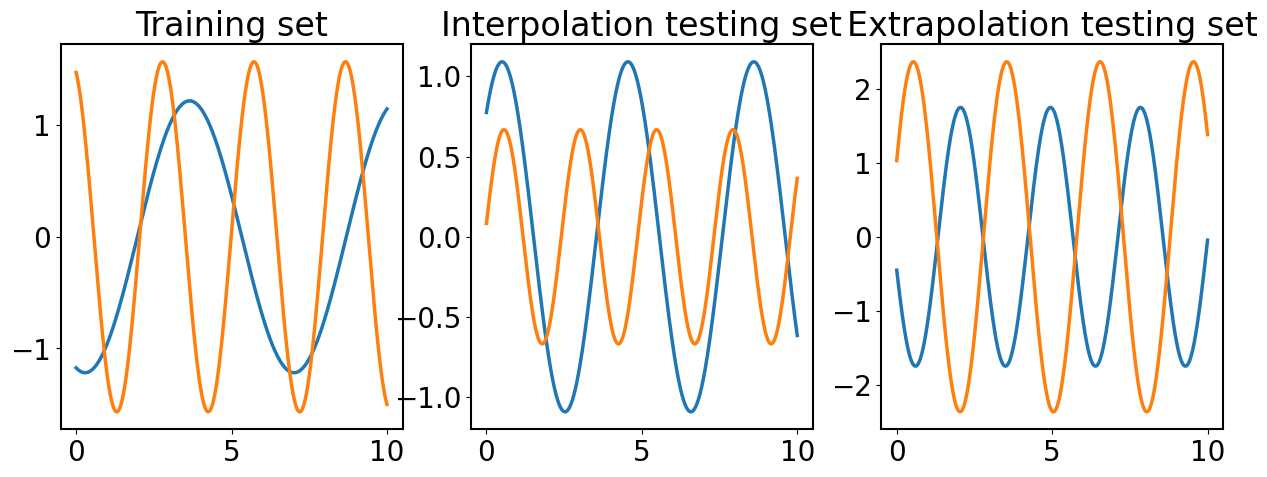

In [149]:
train_demo = 1
test_demo = 12
nb_demo = train_demo + test_demo
N = 10000
dt = 1e-2
pi = np.pi
x_dim = 2

t = np.linspace(0, dt*N, N)[None][...,None]
###########################################################################################################
A_train = np.random.uniform(low=-pi/2, high=pi/2, size=(train_demo,x_dim//2))[:, None]

A_test_ext = np.concatenate([
    np.random.uniform(low=-pi+0.01, high=-pi/2, size=(test_demo//4,x_dim//2))[:, None],
    np.random.uniform(low=pi/2, high=pi-0.01, size=(test_demo//4,x_dim//2))[:, None]
],0)

A_test_int = np.random.uniform(low=-pi/2, high=pi/2, size=(test_demo//2,x_dim//2))[:, None]

A = np.concatenate([A_train, A_test_int, A_test_ext], 0)
###########################################################################################################

phi = np.random.uniform(low=-pi, high=pi, size=(nb_demo,x_dim//2))[:, None]
###########################################################################################################

f = np.random.uniform(low=0.1, high=0.4, size=(nb_demo,x_dim//2))[:, None]

w = 2*pi*f
###########################################################################################################

x_train = A_train*np.cos(w[:A_train.shape[0]]*t+phi[:A_train.shape[0]])

x_test_int = A_test_int*np.cos(1.1*w[A_train.shape[0]:A_train.shape[0]+test_demo//2]*t+phi[A_train.shape[0]:A_train.shape[0]+test_demo//2])

x_test_ext = A_test_ext*np.cos(w[A_train.shape[0]+test_demo//2:]*t+phi[A_train.shape[0]+test_demo//2:])
###########################################################################################################

fig,ax = plt.subplots(ncols=3, figsize=(15,5))
for x_train_, x_test_1, x_test_2  in zip(x_train, x_test_int, x_test_ext):
    _ = ax[0].plot(t[0],x_train_)
    _ = ax[1].plot(t[0],x_test_1)
    _ = ax[2].plot(t[0],x_test_2)

ax[0].set_title("Training set")
ax[1].set_title("Interpolation testing set")
ax[2].set_title("Extrapolation testing set")
print(x_train.shape)

In [ ]:
# Simple sinusoids ###################################################    
# time = np.arange(0,20,dt)
# pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(70),0]), dt=dt)
# pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(120),0]), dt=dt)
# # # Reference design
# freq1, freq2 = .125, .125
# pend1.T_ref, pend2.T_ref = 1/freq1/pend1.dt, 1/freq2/pend2.dt
# amplitude1, amplitude2 = 40, 50 # deg
# pend1.ref = sineReference(pend1.N, pend1.dt, pend1.T_ref, amplitude1, 70)
# pend2.ref = sineReference(pend2.N, pend1.dt, pend2.T_ref, amplitude2, 120)

# for i in range(pend1.N-1):
#     if i <= pend1.N:
#         Kp, Ki, Kd = 70, 1, 5
#     else:
#         Kp, Ki, Kd = 10, 2.5, 5
#     pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 80, limit=200)[0]
#     pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
#     pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 90, 11, 25, pend2.dt, 40, limit=200)[0]
#     pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
ref1 = varSine([30,50,80,100,140], [.5,.5,.5,.5,.5], 4*np.array([1,1,1,1,1]), [0,0,0,0,0], dt)
ref2 = varSine([30,50,80,50,10], [.5,.5,.5,.5,.5], 4*np.array([1,1,1,1,1]), [60,80,90,100,100], dt)

time = np.arange(0,len(ref1)*dt,dt)
pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(60),0]), dt=dt)
pend1.ref, pend2.ref = ref1, ref2

for i in range(pend1.N-1):
    if i <= pend1.N:
        Kp, Ki, Kd = 50, 20, 5
    else:
        Kp, Ki, Kd = 10, 2.5, 5
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 20, limit=200)[0] 
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 60, 11, 25, pend2.dt, 40, limit=200)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,0].plot(pend1.T, rad2deg(np.array(pend1.ref)), label=r"$reference \ r_1$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend2.T, rad2deg(np.array(pend2.ref)), label=r"$reference \ r_2$")
ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()
ax[0,0].set_title('Reference for training'), ax[0,1].set_title('Reference for testing')

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend2.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_ylabel('Angular speed [deg/s]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

ax[2,0].plot(pend1.T[:pend1.N-1], pend1.U, label='u(t)')
ax[2,1].plot(pend2.T[:pend1.N-1], pend2.U, label='u(t)')
ax[2,0].set_xlabel('Time [s]'), ax[2,0].set_ylabel('Torque [Nm]'), ax[2,1].set_xlabel('Time [s]')
ax[2,0].grid(), ax[2,1].grid()
ax[2,0].legend(), ax[2,1].legend()


## Creating a nasty sine-ish reference

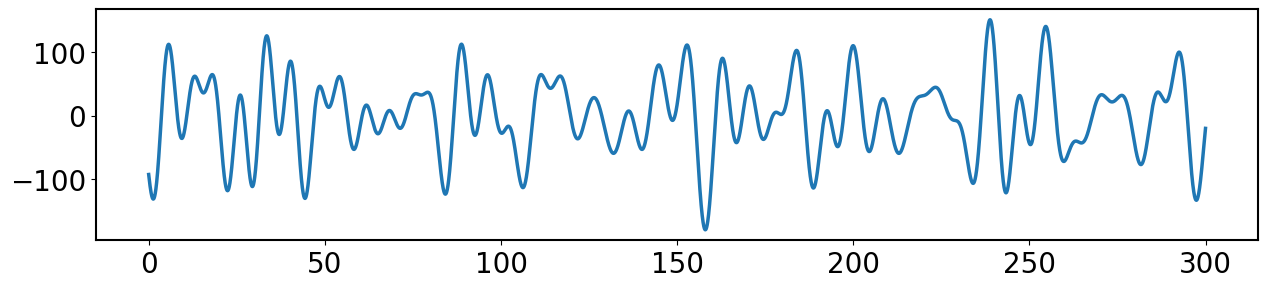

In [119]:
###############################
N = 30000
dt = 1e-2
pi = np.pi
nb_parts = 100
phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
###############################
time = np.arange(0,N,1)
t = np.arange(0,N*dt,dt)
pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(60),0]), dt=dt)
###############################
x_train = 0
for i in range(nb_parts):
    x_train = x_train + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    
x_train = x_train/max(max(x_train),-min(x_train))*pi
pend1.ref = x_train
###############################
fig, ax = plt.subplots(ncols=1, figsize=(15,3))
ax.plot(t,rad2deg(x_train))

## Simulate with nasty sine to retrieve training set

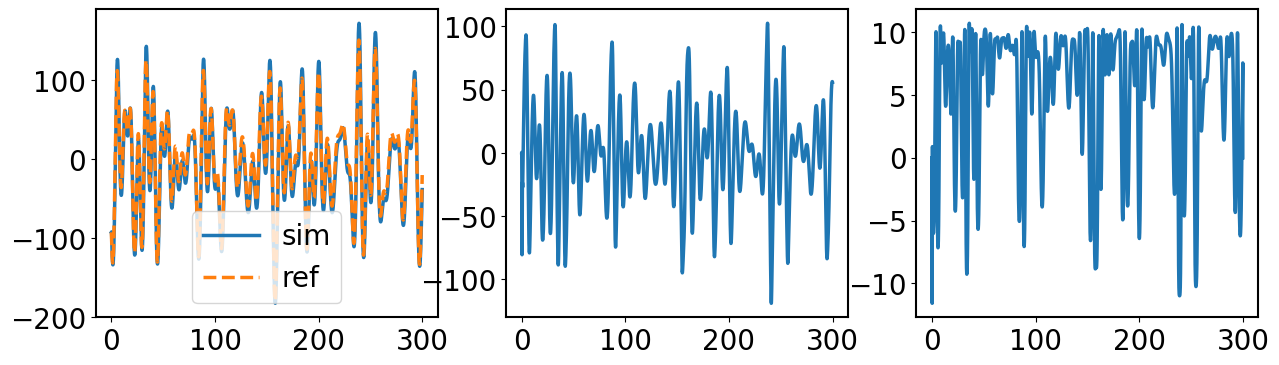

In [120]:
Kp, Ki, Kd = 50, 20, 5
U_train = np.zeros(shape=[N])
X_train = np.zeros(shape=[2,N])
X_train[0,0] = x_train[0]
##############################################
for i in range(N-1):
    U_train[i] = PID(X_train, i, x_train[i], Kp, Kd, Ki, pend1.dt, 20, limit=[-20,20])[0] 
    X_train[:,i+1] = RK4(pend1.dynamics, X_train[:,i], U_train[i], pend1.dt, type='controller-step-by-step')
#         pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 60, 11, 25, pend2.dt, 40, limit=200)[0]
#         pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
pend1.X = X_train
pend1.U = U_train
# LEARN ON DIFFERENCES #######################
# X_diff = X_train[:,1:] - X_train[:,0:N-1]
# U_diff = U_train[1:N] - U_train[0:N-1]
# pend1.X, pend1.U = X_diff, U_diff
# pend1.N = pend1.N-1
##############################################
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

ax[0].plot(t,rad2deg(X_train[0,:]),label='sim'), ax[0].plot(t,rad2deg(x_train),linestyle='dashed',label='ref'),ax[0].legend()
ax[1].plot(t,rad2deg(X_train[1,:]))
ax[2].plot(t,U_train)

# Observing trajectories in subspace

## First train linear model

### Vary delay and delay spacing

In [115]:
# FIXED PARAMETERS #####################################
pend = pend1
horizon = np.int(.005*pend.N)
model1 = HAVOK(pend.X, pend.U)
# SWEEP THROUGH PARAMETERS #############################
Delay_spacing = np.arange(1,np.int(.8*pend.N/horizon),50)
Tau = np.arange(5,16,1)
residuals = np.empty(shape=[2,len(Delay_spacing),len(Tau)])
traj_error = np.empty(shape=[2,len(Delay_spacing),len(Tau)])
for i in range(len(Tau)):
    for j in range(len(Delay_spacing)):
        model1.HANKEL(horizon, delay_spacing=np.int(Delay_spacing[j]))
        model1.SVD(Tau[i])
        model1.LS(Tau[i],rcond=0)
        model1.Simulate(X_train[:,0],U_testing = U_train)
        model1.TrajError(pend.X)
        
        residuals[:,j,i] = model1.residuals
        traj_error[:,j,i] = model1.traj_error
        if traj_error[0,j,i] >= .5e3: traj_error[0,j,i] = .5e3
        if traj_error[1,j,i] >= .5e3: traj_error[1,j,i] = .5e3

### Vary delay spacing and number of trajectory

In [145]:
# FIXED PARAMETERS #####################################
pend = pend1
Tau = np.array([7,9,10,12,14])
model1 = HAVOK(pend.X, pend.U)
# SWEEP THROUGH PARAMETERS #############################
Horizon = np.arange(20,150,20)
Delay_spacing = np.arange(10,np.int(.8*pend.N/max(Horizon)-1),20)
residuals = np.empty(shape=[len(Tau),2,len(Delay_spacing),len(Horizon)])
traj_error = np.empty(shape=[len(Tau),2,len(Delay_spacing),len(Horizon)])
for t in range(len(Tau)):
    for i in range(len(Horizon)):
        for j in range(len(Delay_spacing)):
            model1.HANKEL(Horizon[i], delay_spacing=Delay_spacing[j])
            model1.SVD(Tau[t])
            model1.LS(Tau[t],rcond=0)
            model1.Simulate(X_train[:,0],U_testing = U_train)
            model1.TrajError(pend.X)

            residuals[t,:,j,i] = model1.residuals
            traj_error[t,:,j,i] = model1.traj_error
            if (traj_error[t,0,j,i] >= .5e3)or(np.isnan(traj_error[t,0,j,i])): traj_error[t,0,j,i] = .5e3
            if (traj_error[t,1,j,i] >= .5e3)or(np.isnan(traj_error[t,1,j,i])): traj_error[t,1,j,i] = .5e3

Min of trajectory error in position : ( 50 , 100 ) Value for pos. :  212.02468675150723 Value for vel. :  126.67263914132623 , delay =  7
Min of trajectory error in velocity : ( 50 , 100 ) Value for pos. :  212.02468675150723 Value for vel. :  126.67263914132623 , delay =  7
Min of trajectory error in position : ( 150 , 40 ) Value for pos. :  187.80359401105054 Value for vel. :  95.77240810850408 , delay =  9
Min of trajectory error in velocity : ( 150 , 40 ) Value for pos. :  187.80359401105054 Value for vel. :  95.77240810850408 , delay =  9
Min of trajectory error in position : ( 130 , 140 ) Value for pos. :  160.0207665296384 Value for vel. :  98.21322063512658 , delay =  10
Min of trajectory error in velocity : ( 70 , 80 ) Value for pos. :  171.8962264814193 Value for vel. :  92.0686198882769 , delay =  10
Min of trajectory error in position : ( 110 , 140 ) Value for pos. :  164.1703810894596 Value for vel. :  102.56951983855049 , delay =  12
Min of trajectory error in velocity : 

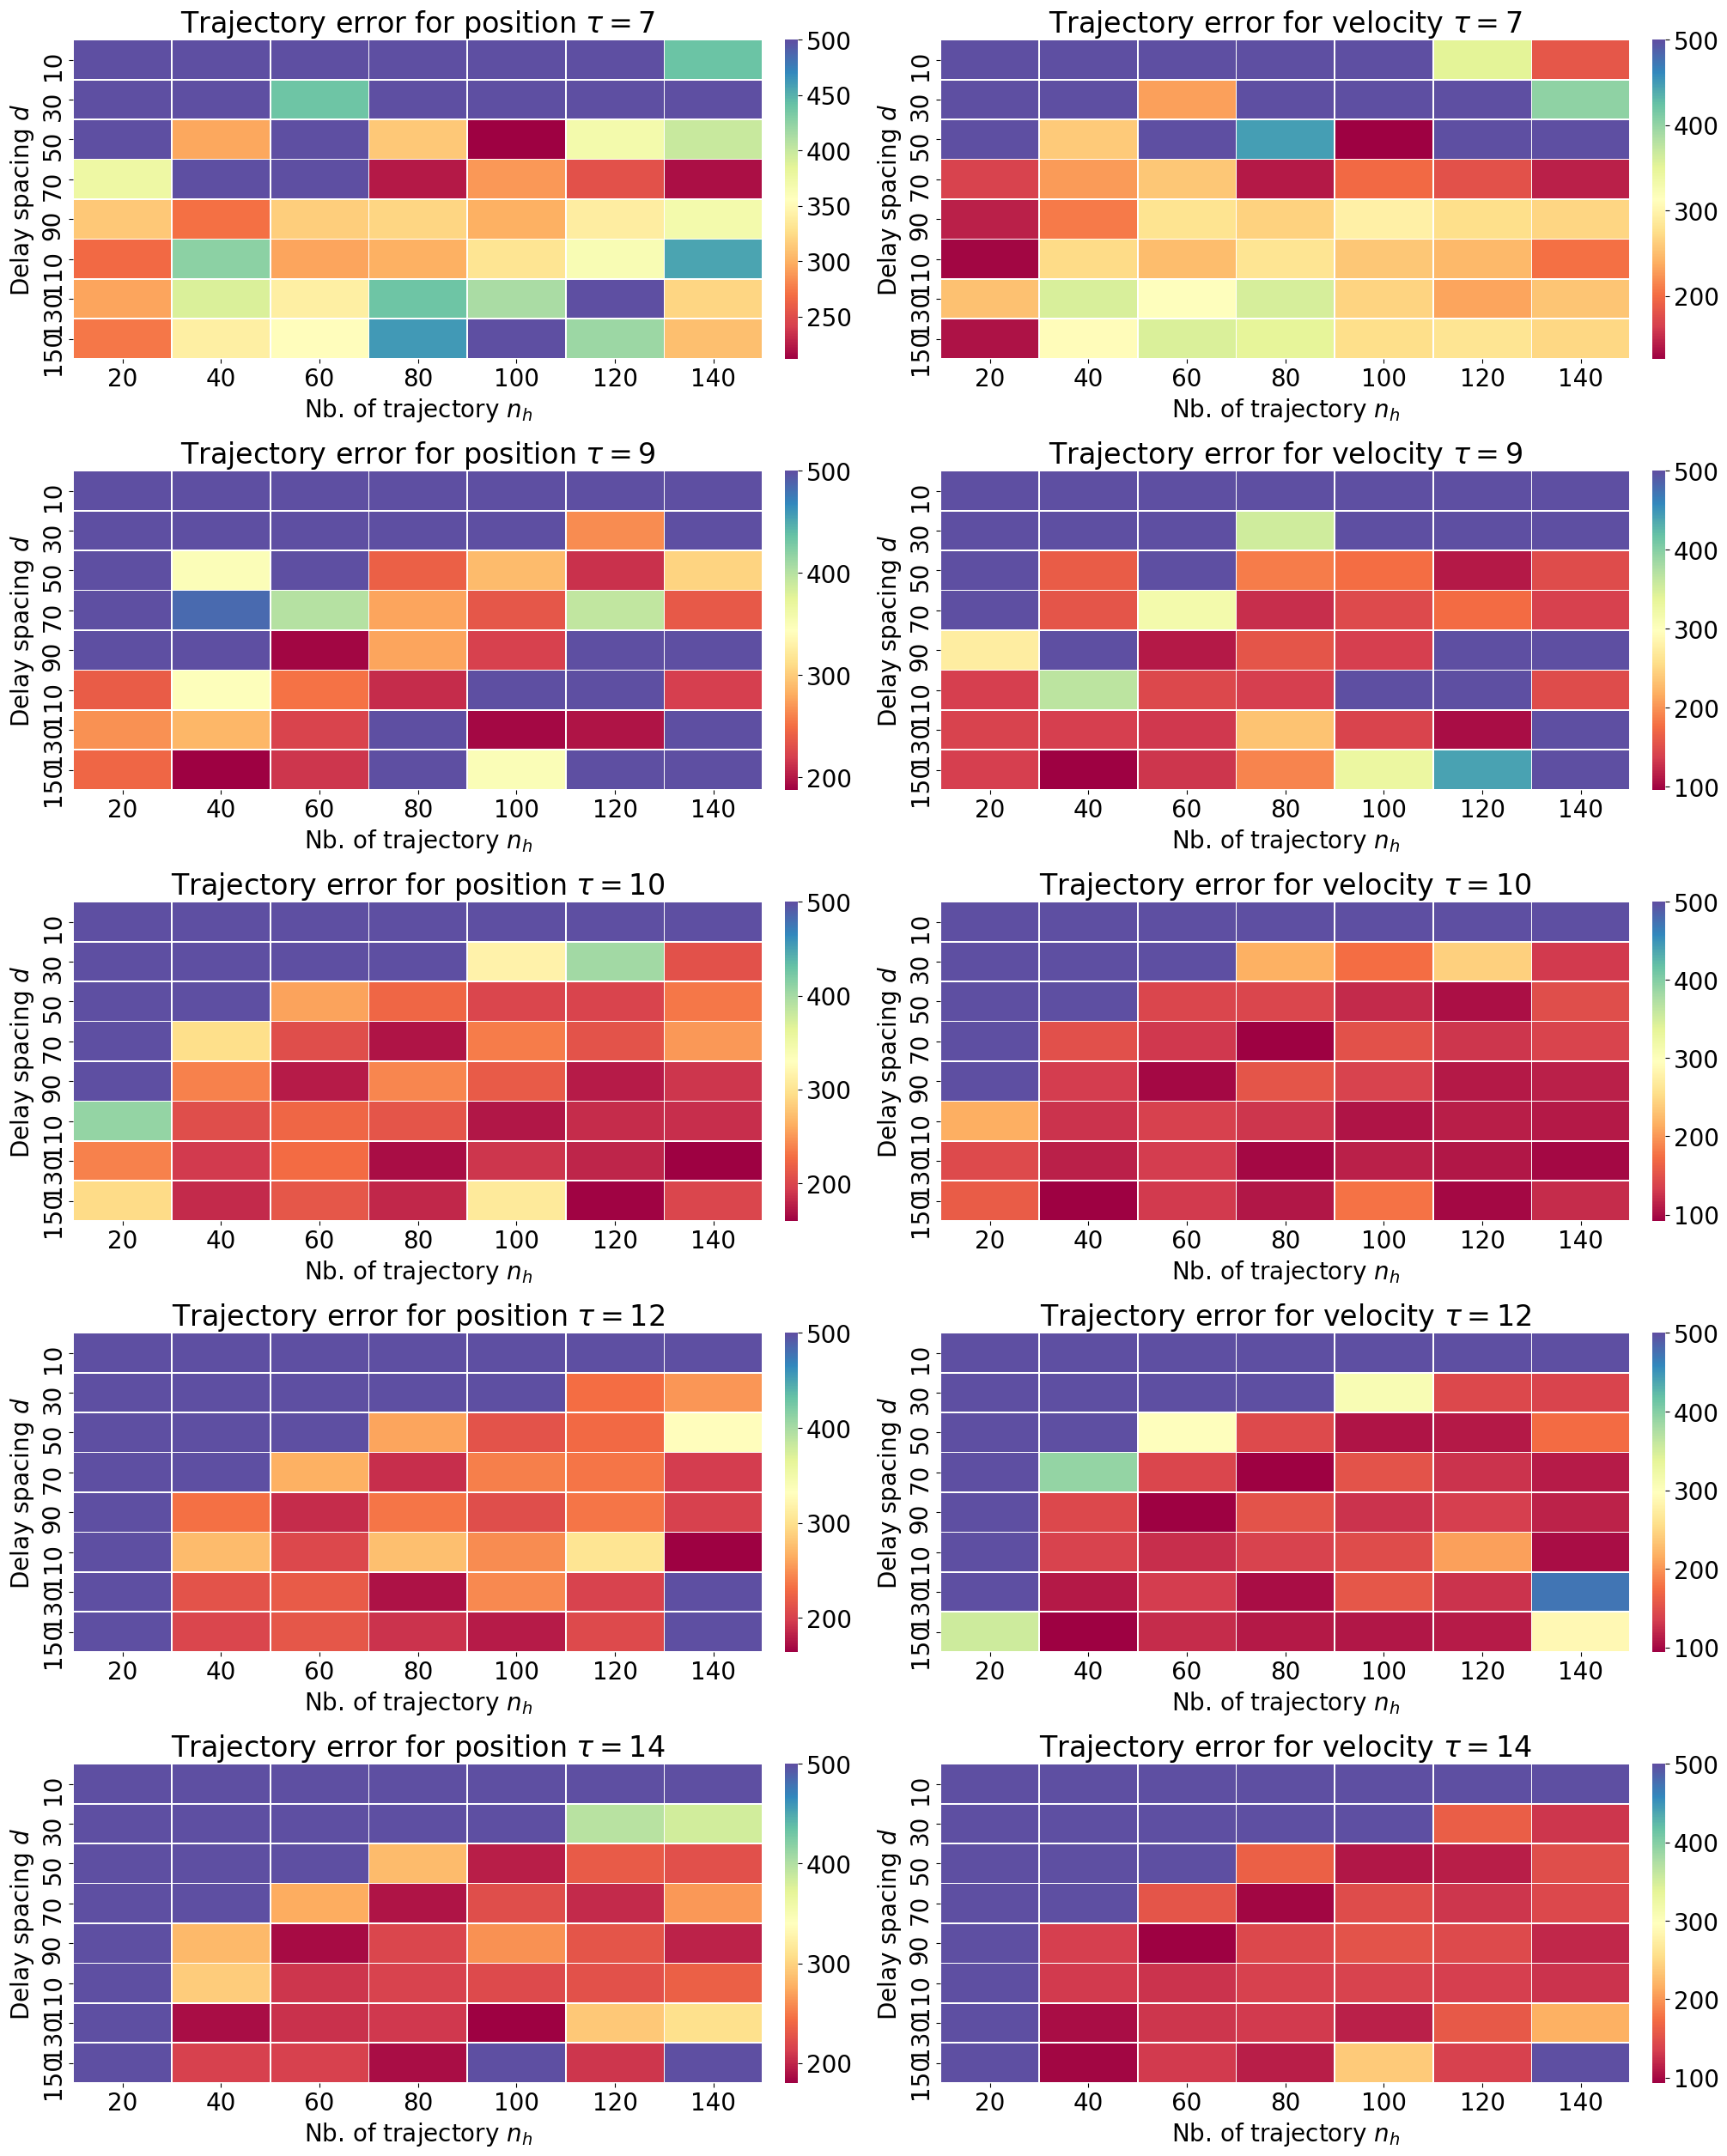

In [148]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(len(Tau),2, 
                       constrained_layout = True, figsize=(20,5*len(Tau)))

for t in range(len(Tau)):

    ax[t,0].set_title(r'Trajectory error for position $\tau = $'+str(Tau[t]))
    snb.heatmap(traj_error[t,0,:,:],cmap='Spectral',ax=ax[t,0],linewidths=.5)
    ax[t,0].set_xlabel(r'Nb. of trajectory $n_h$'), ax[t,0].set_ylabel(r'Delay spacing $d$')
    ax[t,0].set_xticks(np.arange(0.5,len(Horizon),1)), ax[t,0].set_yticks(np.arange(0.5,len(Delay_spacing),1))
    ax[t,0].set_xticklabels(Horizon), ax[t,0].set_yticklabels(Delay_spacing)

    ax[t,1].set_title(r'Trajectory error for velocity $\tau = $'+str(Tau[t]))
    snb.heatmap(traj_error[t,1,:,:],cmap='Spectral',ax=ax[t,1],linewidths=.5)
    ax[t,1].set_xlabel(r'Nb. of trajectory $n_h$'), ax[t,1].set_ylabel(r'Delay spacing $d$')
    ax[t,1].set_xticks(np.arange(0.5,len(Horizon),1)), ax[t,1].set_yticks(np.arange(0.5,len(Delay_spacing),1))
    ax[t,1].set_xticklabels(Horizon), ax[t,1].set_yticklabels(Delay_spacing)
    
    index = np.argmin(traj_error[t,0,:,:])
    pos_y, pos_x = index//len(Horizon), index%len(Horizon)
    print('Min of trajectory error in position : (',Delay_spacing[pos_y],',',Horizon[pos_x],')','Value for pos. : ',traj_error[t,0,pos_y,pos_x],
          'Value for vel. : ',traj_error[t,1,pos_y,pos_x],', delay = ',Tau[t])

    index = np.argmin(traj_error[t,1,:,:])
    pos_y, pos_x = index//len(Horizon), index%len(Horizon)
    print('Min of trajectory error in velocity : (',Delay_spacing[pos_y],',',Horizon[pos_x],')','Value for pos. : ',traj_error[t,0,pos_y,pos_x],
          'Value for vel. : ',traj_error[t,1,pos_y,pos_x],', delay = ',Tau[t])

#     ax[1,0].set_title(r'Trajectory error for position $\tau = $'+str(Tau[1]))
#     snb.heatmap(traj_error[1,0,:,:],cmap='Spectral',ax=ax[1,0],linewidths=.5)
#     ax[1,0].set_xlabel(r'Nb. of trajectory $n_h$'), ax[1,0].set_ylabel(r'Delay spacing $d$')
#     ax[1,0].set_xticks(np.arange(0.5,len(Horizon),1)), ax[1,0].set_yticks(np.arange(0.5,len(Delay_spacing),1))
#     ax[1,0].set_xticklabels(Horizon), ax[1,0].set_yticklabels(Delay_spacing)

#     ax[0,1].set_title(r'Trajectory error for velocity $\tau = $'+str(Tau[1]))
#     snb.heatmap(traj_error[1,1,:,:],cmap='Spectral',ax=ax[1,1],linewidths=.5)
#     ax[0,1].set_xlabel(r'Nb. of trajectory $n_h$'), ax[0,1].set_ylabel(r'Delay spacing $d$')
#     ax[0,1].set_xticks(np.arange(0.5,len(Horizon),1)), ax[0,1].set_yticks(np.arange(0.5,len(Delay_spacing),1))
#     ax[0,1].set_xticklabels(Horizon), ax[0,1].set_yticklabels(Delay_spacing)

# ax[1,0].set_title('Residuals error for position')
# snb.heatmap(np.log(residuals[0,:,:]),cmap='Spectral',ax=ax[1,0],linewidths=.5)
# ax[1,0].set_xlabel(r'Nb. of trajectory $n_h$'), ax[1,0].set_ylabel(r'Delay spacing $d$')
# ax[1,0].set_xticks(np.arange(0.5,len(Horizon),1)), ax[1,0].set_yticks(np.arange(0.5,len(Delay_spacing),1))
# ax[1,0].set_xticklabels(Horizon), ax[1,0].set_yticklabels(Delay_spacing)
# ax[1,1].set_title('Residuals error for velocity')
# snb.heatmap(np.log(residuals[1,:,:]),cmap='Spectral',ax=ax[1,1],linewidths=.5)
# ax[1,1].set_xlabel(r'Nb. of trajectory $n_h$'), ax[1,1].set_ylabel(r'Delay spacing $d$')
# ax[1,1].set_xticks(np.arange(0.5,len(Horizon),1)), ax[1,1].set_yticks(np.arange(0.5,len(Delay_spacing),1))
# ax[1,1].set_xticklabels(Horizon), ax[1,1].set_yticklabels(Delay_spacing)
                                                                  
# index = np.argmin(traj_error[0,0,:,:])
# pos_y, pos_x = index//len(Horizon), index%len(Horizon)
# print('Min of trajectory error in position : (',Delay_spacing[pos_y],',',Tau[pos_x],')','Value for pos. : ',traj_error[0,0,pos_y,pos_x],
#       'Value for vel. : ',traj_error[0,1,pos_y,pos_x])

# index = np.argmin(traj_error[0,1,:,:])
# pos_y, pos_x = index//len(Horizon), index%len(Horizon)
# print('Min of trajectory error in velocity : (',Delay_spacing[pos_y],',',Tau[pos_x],')','Value for pos. : ',traj_error[0,0,pos_y,pos_x],
#       'Value for vel. : ',traj_error[0,1,pos_y,pos_x])

# index = np.argmin(traj_error[1,0,:,:])
# pos_y, pos_x = index//len(Horizon), index%len(Horizon)
# print('Min of trajectory error in position : (',Delay_spacing[pos_y],',',Tau[pos_x],')','Value for pos. : ',traj_error[1,0,pos_y,pos_x],
#       'Value for vel. : ',traj_error[1,1,pos_y,pos_x])

# index = np.argmin(traj_error[1,1,:,:])
# pos_y, pos_x = index//len(Horizon), index%len(Horizon)
# print('Min of trajectory error in velocity : (',Delay_spacing[pos_y],',',Tau[pos_x],')','Value for pos. : ',traj_error[1,0,pos_y,pos_x],
#       'Value for vel. : ',traj_error[1,1,pos_y,pos_x])

# index = np.argmin(residuals[0,:,:])
# pos_y, pos_x = index//len(Horizon), index%len(Horizon)
# print('Min of residuals in position : (',Delay_spacing[pos_y],',',Tau[pos_x],')','Value for pos. : ',residuals[0,pos_y,pos_x],
#       'Value for vel. : ',residuals[1,pos_y,pos_x])

# index = np.argmin(residuals[1,:,:])
# pos_y, pos_x = index//len(Horizon), index%len(Horizon)
# print('Min of residuals in velocity : (',Delay_spacing[pos_y],',',Tau[pos_x],')','Value for pos. : ',residuals[0,pos_y,pos_x],
#       'Value for vel. : ',residuals[1,pos_y,pos_x])

In [ ]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(2,2, 
                       constrained_layout = True, figsize=(20,15))
ax[0,0].set_title('Trajectory error for position')
snb.heatmap(traj_error[0,:,:],cmap='Spectral',ax=ax[0,0],linewidths=.5)
ax[0,0].set_xticks(np.arange(0.5,len(Tau),1)), ax[0,0].set_yticks(np.arange(0.5,len(Delay_spacing),1))
ax[0,0].set_xticklabels(Tau), ax[0,0].set_yticklabels(Delay_spacing)
ax[0,0].set_xlabel(r'Subspace dimension $r$'), ax[0,0].set_ylabel(r'Delay spacing $d$')
ax[0,1].set_title('Trajectory error for velocity')
snb.heatmap(traj_error[1,:,:],cmap='Spectral',ax=ax[0,1],linewidths=.5)
ax[0,1].set_xlabel(r'Subspace dimension $r$'), ax[0,1].set_ylabel(r'Delay spacing $d$')
ax[0,1].set_xticks(np.arange(0.5,len(Tau),1)), ax[0,1].set_yticks(np.arange(0.5,len(Delay_spacing),1))
ax[0,1].set_xticklabels(Tau), ax[0,1].set_yticklabels(Delay_spacing)
ax[1,0].set_title('Residuals error for position')
snb.heatmap(np.log(residuals[0,:,:]),cmap='Spectral',ax=ax[1,0],linewidths=.5)
ax[1,0].set_xlabel(r'Subspace dimension $r$'), ax[1,0].set_ylabel(r'Delay spacing $d$')
ax[1,0].set_xticks(np.arange(0.5,len(Tau),1)), ax[1,0].set_yticks(np.arange(0.5,len(Delay_spacing),1))
ax[1,0].set_xticklabels(Tau), ax[1,0].set_yticklabels(Delay_spacing)
ax[1,1].set_title('Residuals error for velocity')
snb.heatmap(np.log(residuals[1,:,:]),cmap='Spectral',ax=ax[1,1],linewidths=.5)
ax[1,1].set_xlabel(r'Subspace dimension $r$'), ax[1,1].set_ylabel(r'Delay spacing $d$')
ax[1,1].set_xticks(np.arange(0.5,len(Tau),1)), ax[1,1].set_yticks(np.arange(0.5,len(Delay_spacing),1))
ax[1,1].set_xticklabels(Tau), ax[1,1].set_yticklabels(Delay_spacing)
                                                                  
index = np.argmin(traj_error[0,:,:])
pos_y, pos_x = index//len(Tau), index%len(Tau)
print('Min of trajectory error in position : (',Delay_spacing[pos_y],',',Tau[pos_x],')','Value for pos. : ',traj_error[0,pos_y,pos_x],
      'Value for vel. : ',traj_error[1,pos_y,pos_x])

index = np.argmin(traj_error[1,:,:])
pos_y, pos_x = index//len(Tau), index%len(Tau)
print('Min of trajectory error in velocity : (',Delay_spacing[pos_y],',',Tau[pos_x],')','Value for pos. : ',traj_error[0,pos_y,pos_x],
      'Value for vel. : ',traj_error[1,pos_y,pos_x])

index = np.argmin(residuals[0,:,:])
pos_y, pos_x = index//len(Tau), index%len(Tau)
print('Min of residuals in position : (',Delay_spacing[pos_y],',',Tau[pos_x],')','Value for pos. : ',residuals[0,pos_y,pos_x],
      'Value for vel. : ',residuals[1,pos_y,pos_x])

index = np.argmin(residuals[1,:,:])
pos_y, pos_x = index//len(Tau), index%len(Tau)
print('Min of residuals in velocity : (',Delay_spacing[pos_y],',',Tau[pos_x],')','Value for pos. : ',residuals[0,pos_y,pos_x],
      'Value for vel. : ',residuals[1,pos_y,pos_x])

In [153]:
# FIXED PARAMETERS #####################################
pend = pend1
Tau_2 = 10
model1 = HAVOK(pend.X, pend.U)
# SWEEP THROUGH PARAMETERS #############################
best_spacing, best_horizon = 130, 140
Delay_spacing_2 = np.arange(best_spacing-10,best_spacing+10,2)
Horizon_2 = np.arange(best_horizon-10,best_horizon+10,2)
traj_error_2 = np.empty(shape=[2,len(Delay_spacing_2),len(Horizon_2)])
for i in range(len(Horizon_2)):
    for j in range(len(Delay_spacing_2)):
        model1.HANKEL(Horizon_2[i], delay_spacing=Delay_spacing_2[j])
        model1.SVD(Tau_2)
        model1.LS(Tau_2,rcond=0)
        model1.Simulate(X_train[:,0],U_testing = U_train)
        model1.TrajError(pend.X)
        
        traj_error_2[:,j,i] = model1.traj_error
        if traj_error_2[0,j,i] >= .5e3: traj_error_2[0,j,i] = .5e3
        if traj_error_2[1,j,i] >= .5e3: traj_error_2[1,j,i] = .5e3

Min of trajectory error in position : ( 124 , 146 ) Value for pos. :  158.79101033965176 Value for vel. :  96.04049515822788
Min of trajectory error in velocity : ( 120 , 138 ) Value for pos. :  166.46151303555177 Value for vel. :  95.28009553041358


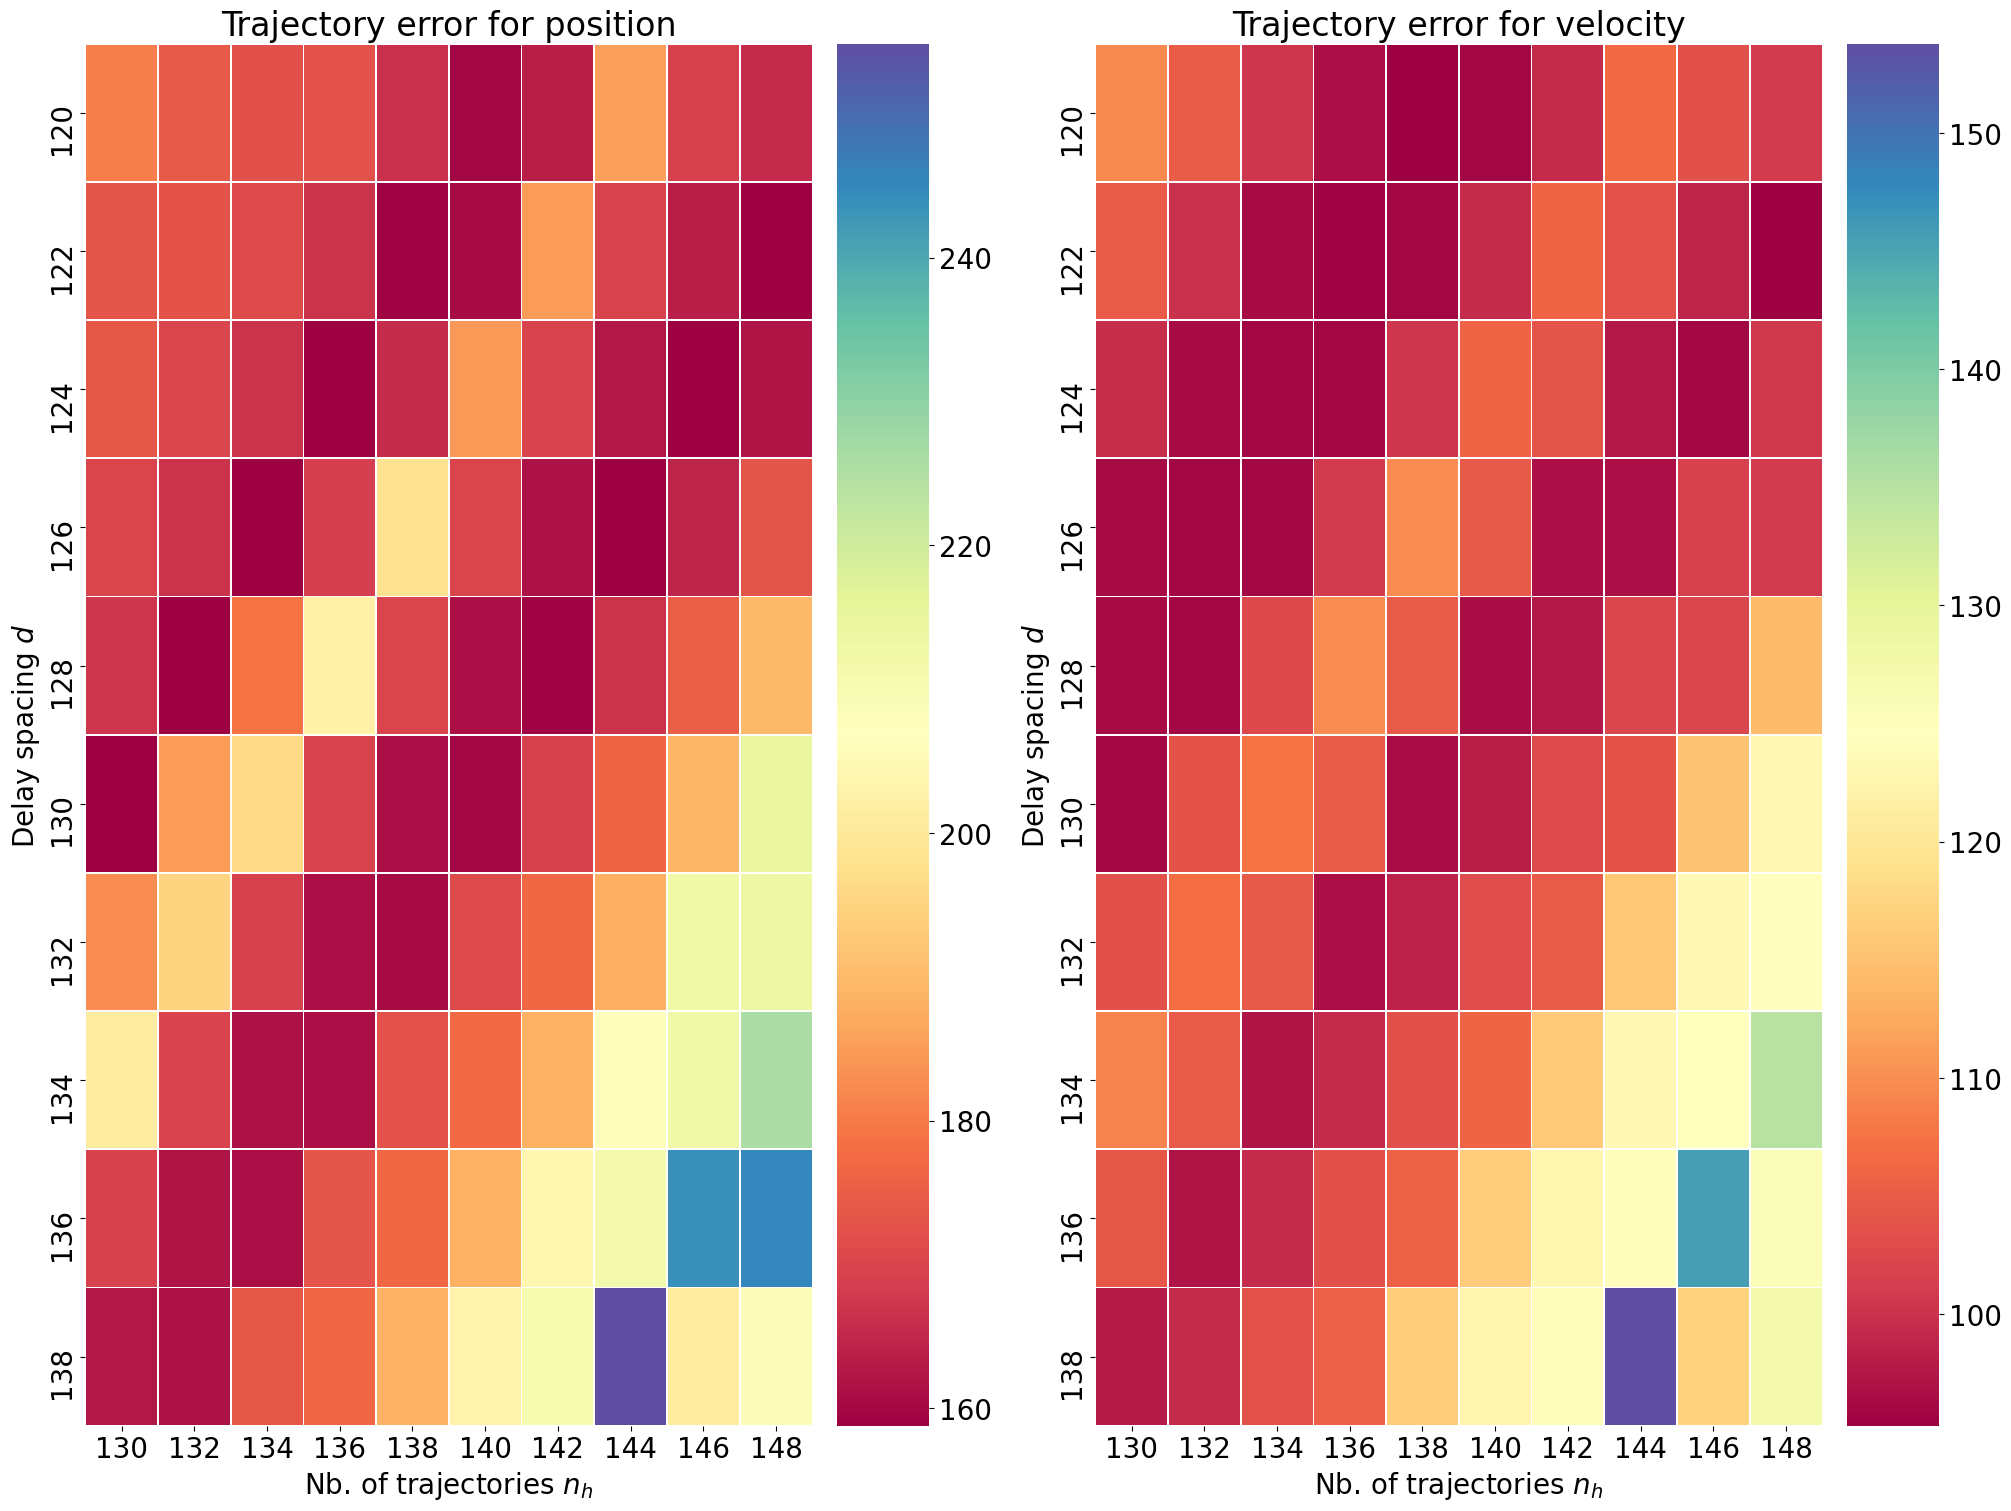

In [155]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,2,
                       constrained_layout = True, figsize=(20,15))
ax[0].set_title('Trajectory error for position')
snb.heatmap(traj_error_2[0,:,:],cmap='Spectral',ax=ax[0],linewidths=.5)
ax[0].set_xlabel(r'Nb. of trajectories $n_h$'), ax[0].set_ylabel(r'Delay spacing $d$')
ax[0].set_xticks(np.arange(0.5,len(Horizon_2),1)), ax[0].set_yticks(np.arange(0.5,len(Delay_spacing_2),1))
ax[0].set_xticklabels(Horizon_2), ax[0].set_yticklabels(Delay_spacing_2)
ax[1].set_title('Trajectory error for velocity')
snb.heatmap(traj_error_2[1,:,:],cmap='Spectral',ax=ax[1],linewidths=.5)
ax[1].set_xlabel(r'Nb. of trajectories $n_h$'), ax[1].set_ylabel(r'Delay spacing $d$')
ax[1].set_xticks(np.arange(0.5,len(Horizon_2),1)), ax[1].set_yticks(np.arange(0.5,len(Delay_spacing_2),1))
ax[1].set_xticklabels(Horizon_2), ax[1].set_yticklabels(Delay_spacing_2)
                                                                  
index = np.argmin(traj_error_2[0,:,:])
pos_y, pos_x = index//len(Horizon_2), index%len(Horizon_2)
print('Min of trajectory error in position : (',Delay_spacing_2[pos_y],',',Horizon_2[pos_x],')','Value for pos. : ',traj_error_2[0,pos_y,pos_x],
      'Value for vel. : ',traj_error_2[1,pos_y,pos_x])

index = np.argmin(traj_error_2[1,:,:])
pos_y, pos_x = index//len(Horizon_2), index%len(Horizon_2)
print('Min of trajectory error in velocity : (',Delay_spacing_2[pos_y],',',Horizon_2[pos_x],')','Value for pos. : ',traj_error_2[0,pos_y,pos_x],
      'Value for vel. : ',traj_error_2[1,pos_y,pos_x])

## Train appropriate linear model

In [157]:
tau = 10
# Training
pend=pend1
model1 = HAVOK(pend.X, pend.U)
# horizon = np.int(len(pend.T)*.7)
horizon = 146
model1.HANKEL(horizon, delay_spacing=124)
model1.SVD(tau)
model1.LS(tau,rcond=0)
model1.Simulate(X_train[:,0],U_testing = U_train)
model1.TrajError(pend.X)
print(model1.H.shape)
print(model1.traj_error)

(292, 11750)
[158.79101  96.0405 ]


## Check what the trajectory really looks like in original space

([<matplotlib.lines.Line2D at 0x27580466910>],
 <matplotlib.legend.Legend at 0x27580466c40>)

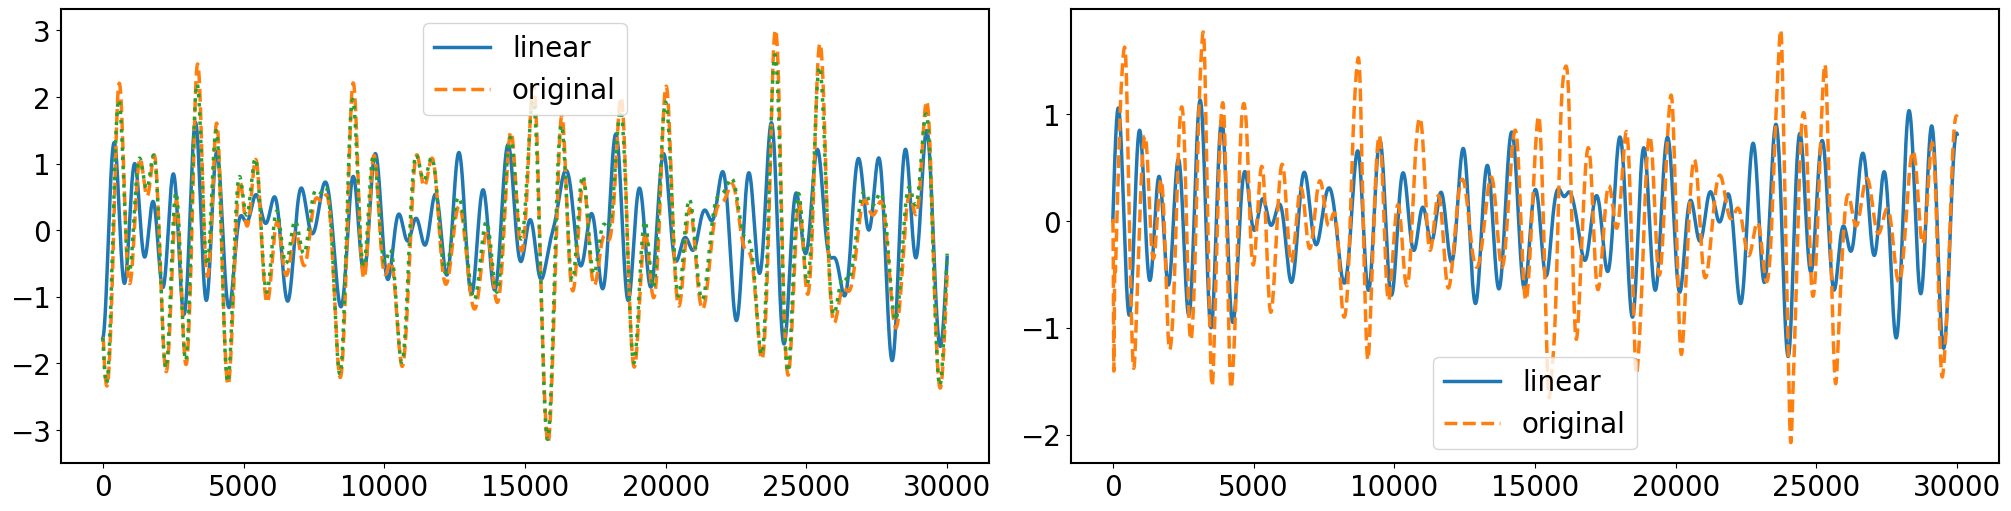

In [158]:
pend = pend1
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(ncols=2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(model1.X_traj[0,:],label='linear'), ax[1].plot(model1.X_traj[1,:],label='linear')
# ax[0].plot(X_train[0,:N-1],label='original',linestyle='dashed'), ax[1].plot(X_train[1,:N-1],label='original',linestyle='dashed')
ax[0].plot(pend.X[0,:],label='original',linestyle='dashed'), ax[1].plot(pend.X[1,:],label='original',linestyle='dashed')
ax[0].plot(np.array(pend.ref),linestyle='dotted'), ax[0].legend(), ax[1].legend()

## Testing

In [164]:
###############################
dt = 1e-2
pi = np.pi
nb_parts = 100
phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
###############################
time = np.arange(0,pend1.N,1)
t = np.arange(0,pend1.N*dt,dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(60),0]), dt=dt)
###############################
x_test = 0
for i in range(nb_parts):
    x_test = x_test + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    
x_test = x_test/max(max(x_test),-min(x_test))*pi
pend2.ref = x_test
###############################
Kp, Ki, Kd = 50, 20, 5
U_test = np.zeros(shape=[pend1.N-1])
X_test = np.zeros(shape=[2,pend1.N])
X_test[0,0] = x_test[0]
###############################
for i in range(pend1.N-1):
    U_test[i] = PID(X_test, i, x_test[i], Kp, Kd, Ki, pend2.dt, 20, limit=[-20,20])[0] 
    X_test[:,i+1] = RK4(pend1.dynamics, X_test[:,i], U_test[i], pend2.dt, type='controller-step-by-step')
pend2.X = X_test
pend2.U = U_test

(292, 11750)
[247.67991 159.39242]


([<matplotlib.lines.Line2D at 0x27582360700>],
 <matplotlib.legend.Legend at 0x27582360a30>)

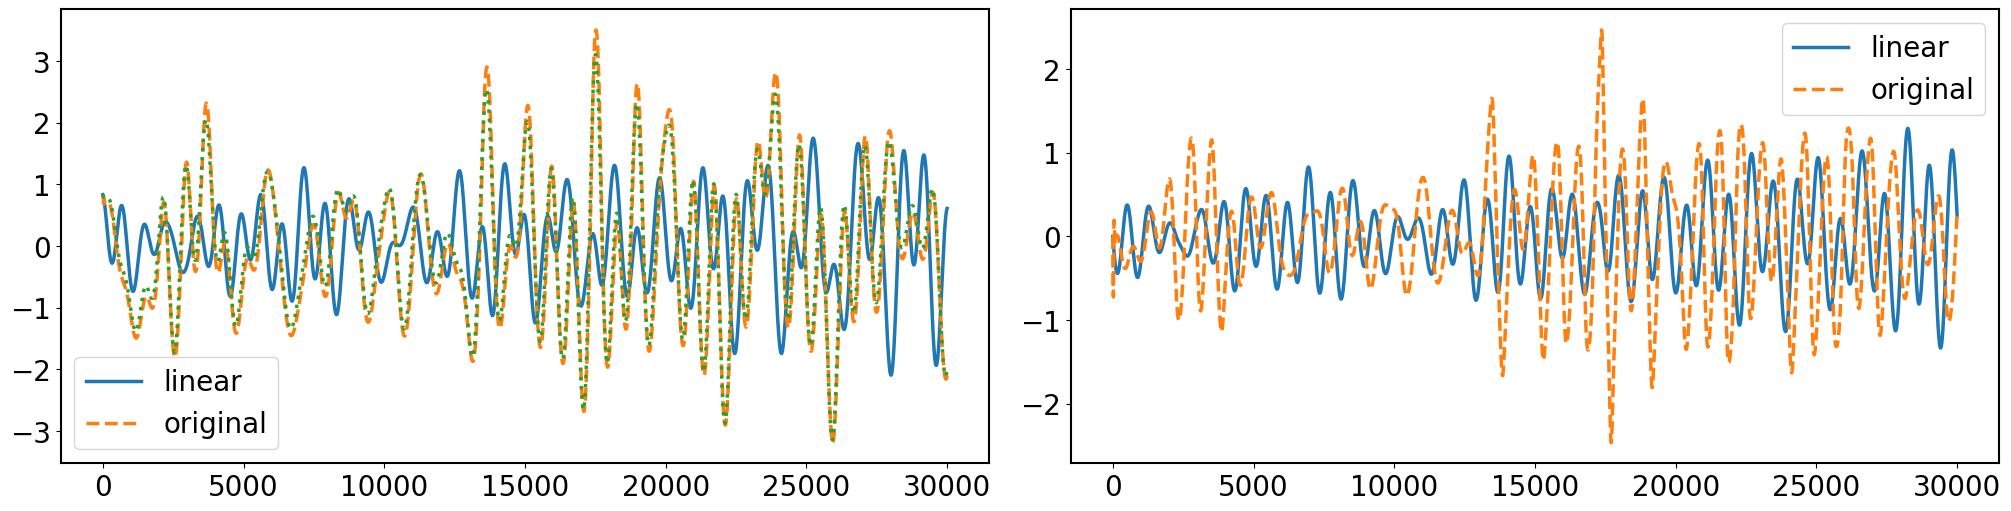

In [165]:
pend = pend2
model1.Simulate(X_test[:,0],U_testing = U_test)
model1.TrajError(pend.X)
print(model1.H.shape)
print(model1.traj_error)
##########################################
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(ncols=2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(model1.X_traj[0,:],label='linear'), ax[1].plot(model1.X_traj[1,:],label='linear')
# ax[0].plot(X_train[0,:N-1],label='original',linestyle='dashed'), ax[1].plot(X_train[1,:N-1],label='original',linestyle='dashed')
ax[0].plot(pend.X[0,:],label='original',linestyle='dashed'), ax[1].plot(pend.X[1,:],label='original',linestyle='dashed')
ax[0].plot(np.array(pend.ref),linestyle='dotted'), ax[0].legend(), ax[1].legend()

## LQR planning

(Text(0.5, 32.16699999999986, 'Horizon'),
 Text(913.4689391120834, 0.5, 'Subspace coordinate $r$'))

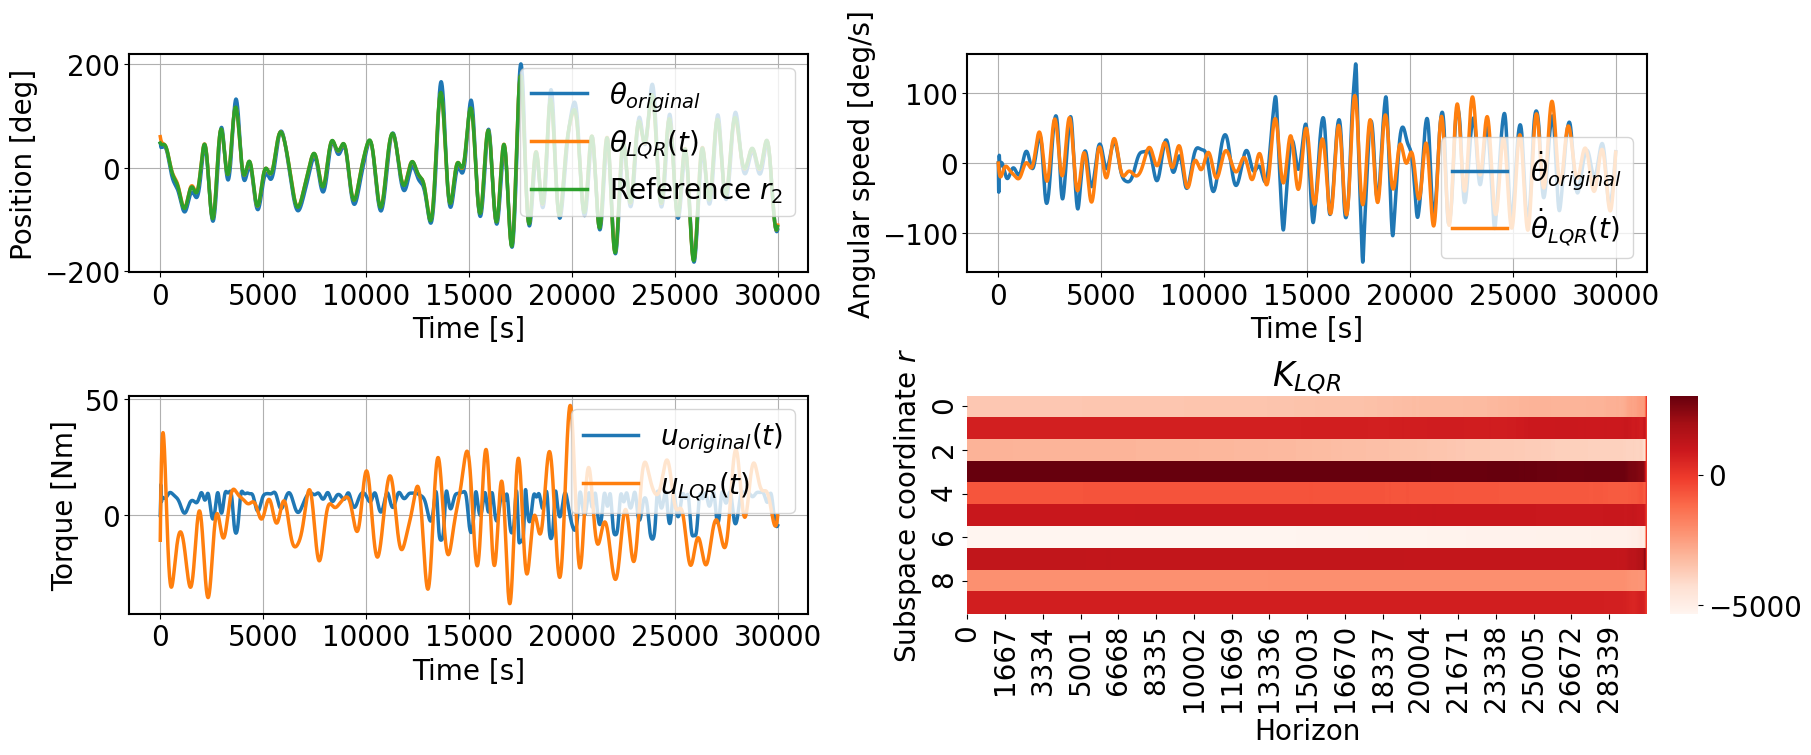

In [167]:
# tau = 7
# # Training
# pend=pend1
# model1 = HAVOK(pend.X, pend.U)
# # horizon = np.int(len(pend.T)*.7)
# horizon = 1500
# model1.HANKEL(horizon)
# model1.SVD(tau)
# model1.LS(tau)
# Testing
pend=pend2
model1.Simulate(pend.X0, U_testing=pend.U)
model1.ConstructLQR(x_std=1e6, u_std=1e0, dt=pend.dt, ref=pend.ref)
model1.LQR_simulate(pend.X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r'$\theta_{original}$')
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref)), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r'$\dot{\theta}_{original}$')
ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], pend.U, label='$u_{original}(t)$')
ax[1,0].plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

In [241]:
pend = pend2
X0 = pend.X0
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-200,200] # Limiting contol input size

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = model1.LQR.get_command(Yc[:,i],i)[0]
    if Uc[i] >= u_max[1]: Uc[i] = u_max[1]
    if Uc[i] <= u_max[0]: Uc[i] = u_max[0]
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
print('LQR cost : ',model1.LQR_cost(Xc, Uc, pend.ref))
    
# Plot
plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(18,9))

gs = fig.add_gridspec(8, 8)

ax00 = fig.add_subplot(gs[0:4,0:4])
ax01 = fig.add_subplot(gs[0:4,4:8])
ax10 = fig.add_subplot(gs[4:8,0:4])
ax11_0 = fig.add_subplot(gs[4:8,4:6])
ax11_1 = fig.add_subplot(gs[4:8,6:8])

ax00.plot(pend.T, rad2deg(pend.X[0,:]), linestyle='dashed', label=r'$\theta_{model-free}$')
ax00.plot(pend.T, rad2deg(model1.LQR_X[:,0]), linestyle=':', label=r'$\theta_{LQR}$')
ax00.plot(pend.T, rad2deg(Xc[0,:]), linestyle='dashdot', label=r"$\theta_{plan}$")
ax00.plot(pend.T, rad2deg(np.array(pend.ref)), linestyle='dashed', label='Ref')
ax00.set_xlabel('Time [s]'), ax00.set_ylabel('Position [deg]')
ax00.grid()
ax00.legend(bbox_to_anchor=(1, 1.2),ncol=5)

ax01.plot(pend.T, rad2deg(pend.X[1,:]), linestyle='dotted', label=r'$\dot{\theta}_{model-free}$')
ax01.plot(pend.T, rad2deg(model1.LQR_X[:,1]), linestyle='dashed', label=r"$\dot{\theta}_{LQR}$")
ax01.plot(pend.T, rad2deg(Xc[1,:]), linestyle='dashed', label=r"$\dot{\theta}_{plan}$")
ax01.set_xlabel('Time [s]'), ax01.set_ylabel('Angular speed [deg/s]')
ax01.grid()
ax01.legend(bbox_to_anchor=(.9, 1.22),ncol=4)

ax10.plot(pend.T[:model1.N-1], pend.U, linestyle='dashed', label='$u_{model-free}$')
ax10.plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], linestyle='dotted', label='$u_{LQR}$')
ax10.plot(pend.T[:model1.N-1], Uc, linestyle='dashdot', label='$u_{plan}$')
ax10.set_xlabel('Time [s]'), ax10.set_ylabel('Torque [Nm]')
ax10.grid()
ax10.legend(bbox_to_anchor=(.9, 1.2),ncol=3)

ax11_0.set_title('$A$')
figA = snb.heatmap(model1.A,cmap='Reds',ax=ax11_0)
ax11_0.set_ylabel('Dimension'), ax11_0.set_xlabel('Dimension')

ax11_1.set_title('$B$')
figA = snb.heatmap(model1.B,cmap='Reds')

# fig.savefig('Images/Pend_HAVOK_trajectories_sine2.svg',format='svg',dpi=800)
fig.savefig('Images/Pend_HAVOK_trajectories_11_11.svg',format='svg',dpi=800)

IndexError: list index out of range

## Pendulum swing-up

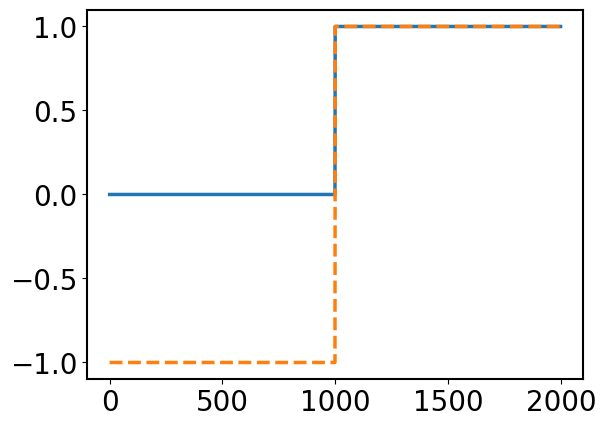

In [217]:
freq = .05
dt = 1e-2
period = 1/freq/dt
pend3 = SimplePendulum(mass=1, length=1, time=np.arange(0,20,dt), X0=np.array([deg2rad(120),0]), dt=dt)
pend = pend3
pend.ref = np.zeros([2,pend.N])
# pend.ref[0,:] = sineReference(pend.N, pend.dt, period, 180, -90)
pend.ref[0,:] = np.hstack((deg2rad(-90)*np.ones(np.int(pend.N/2)),deg2rad(90)*np.ones(np.int(pend.N/2))))
precision1, precision2 = np.zeros(shape=[2,pend.N]), np.zeros(shape=[2,pend.N])
nb = np.int(pend.N/(period/2))

x_std = 1e6
# precision[0,np.int(period/4)::np.int(period/2)] = x_std*np.ones(nb)
precision1[0,np.int(pend.N/2):pend.N] = np.ones(np.int(pend.N/2))*x_std
precision2[0,:pend.N] = np.ones(np.int(pend.N))*x_std
plt.plot(precision1[0,:]/x_std)
plt.plot(pend.ref[0,:]/deg2rad(90),linestyle='dashed')

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(900.1611617686949, 0.5, 'Subspace coordinate $r$'))

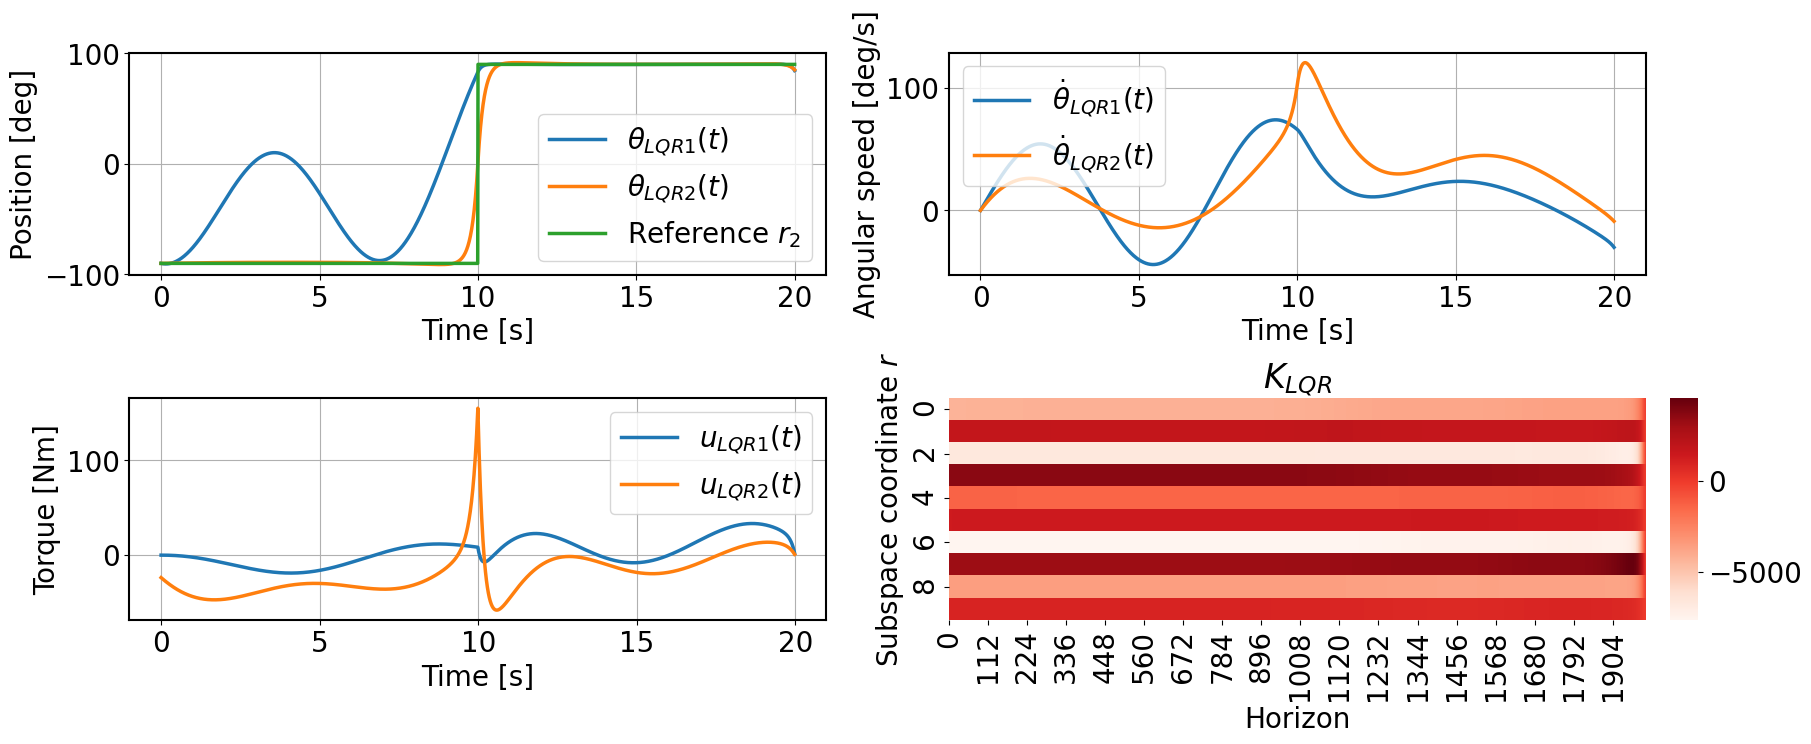

In [239]:
u_std = 10e-2
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, horizon=pend.N, custom_trajectory=precision1)
model1.LQR_simulate(np.array([deg2rad(-90),0]))
LQR1_X, LQR1_U, LQR1 = model1.LQR_X, model1.LQR_U, model1.LQR
u_std = 5e-1
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, horizon=pend.N, custom_trajectory=precision2)
model1.LQR_simulate(np.array([deg2rad(-90),0]))
LQR2_X, LQR2_U, LQR2 = model1.LQR_X, model1.LQR_U, model1.LQR

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(LQR1_X[:,0]), label=r"$\theta_{LQR1} (t)$")
ax[0,0].plot(pend.T, rad2deg(LQR2_X[:,0]), label=r"$\theta_{LQR2} (t)$")
ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(LQR1_X[:,1]), label=r"$\dot{\theta}_{LQR1} (t)$")
ax[0,1].plot(pend.T, rad2deg(LQR2_X[:,1]), label=r"$\dot{\theta}_{LQR2} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:pend.N-1], LQR1_U[0,:,0], label='$u_{LQR1}(t)$')
ax[1,0].plot(pend.T[:pend.N-1], LQR2_U[0,:,0], label='$u_{LQR2}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(897.0563227959315, 0.5, 'Subspace coordinate $r$'))

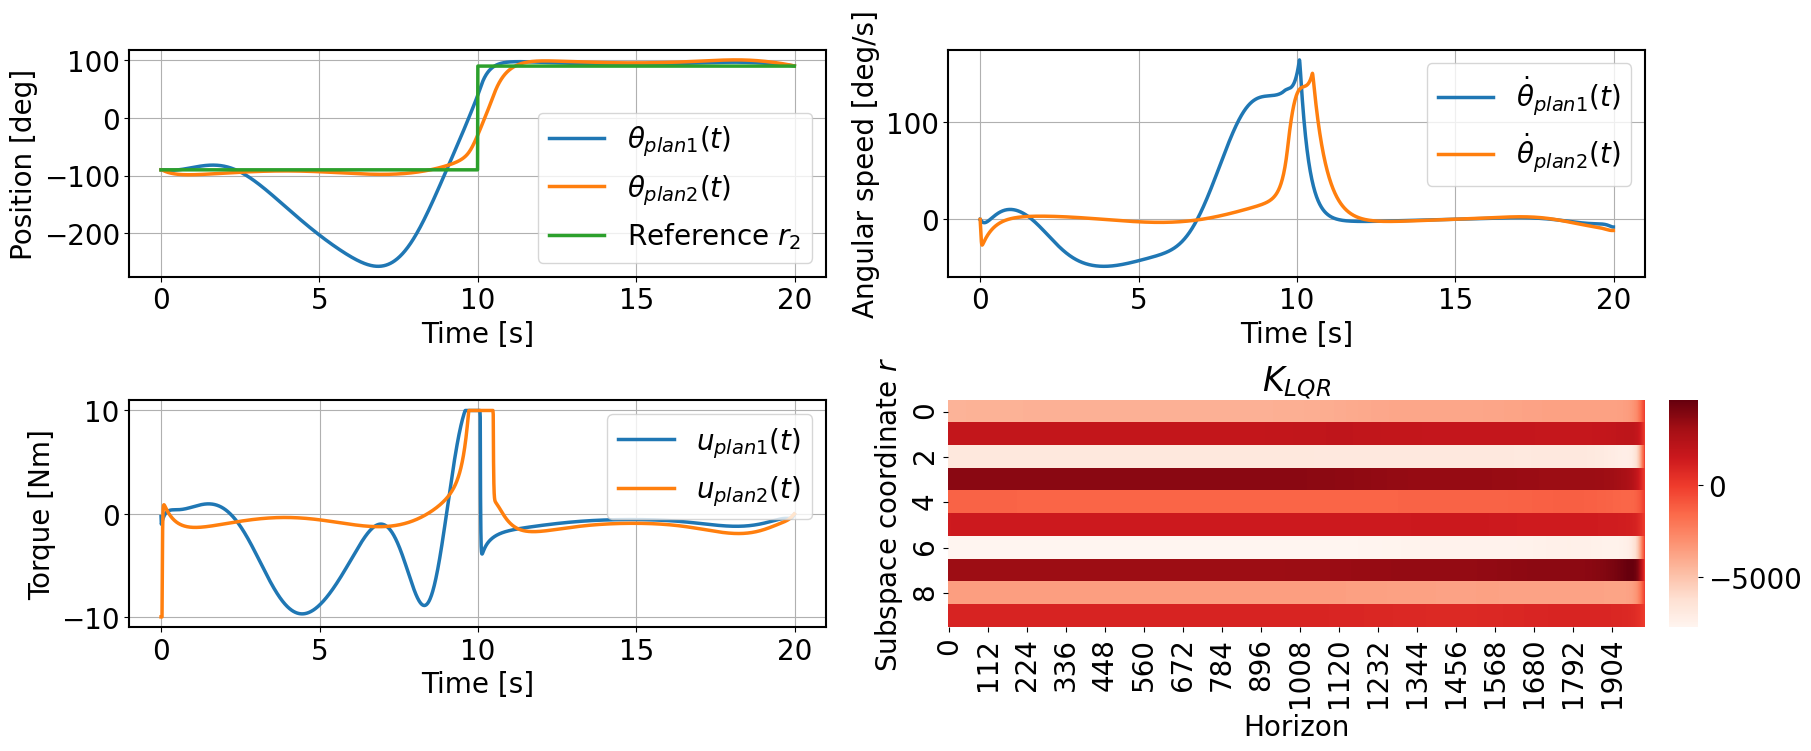

In [240]:
X0 = np.array([deg2rad(-90),0])
Xc, Yc = np.zeros(shape=[2,model1.nb_S,pend.N]), np.zeros(shape=[2,model1.tau,pend.N])
Uc = np.empty(shape=[2,pend.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt
LQR = np.array([LQR1,LQR2])

# Initial condition
Xc[:,:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-10,10]

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(pend.N-1):
    
    for j in range(2):
        Uc[j,i] = LQR[j].get_command(Yc[j,:,i],i)[0]
        
        if Uc[j,i] >= u_max[1]: Uc[j,i] = u_max[1]
        if Uc[j,i] <= u_max[0]: Uc[j,i] = u_max[0]

        Xc[j,:,i+1]= RK4(f, Xc[j,:,i], Uc[j,i], t_interval, type='controller-step-by-step')
        Yc[j,:,i+1] = pinv(model1.C)@Xc[j,:,i+1]
    
# # Evaluate LQR costs
# cost_roll = model1.LQR_cost(model1.LQR_X.T,model1.LQR_U[0,:,0],pend.ref[0,:],horizon=pend.N)
# cost_plan = model1.LQR_cost(Xc,Uc,pend.ref[0,:],horizon=pend.N)
# print('Rollout cost is ',cost_roll/cost_plan*100,' [%] of planning cost')
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(Xc[0,0,:]), label=r"$\theta_{plan1} (t)$")
ax[0,0].plot(pend.T, rad2deg(Xc[1,0,:]), label=r"$\theta_{plan2} (t)$")
ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[0,1,:]), label=r"$\dot{\theta}_{plan1} (t)$")
ax[0,1].plot(pend.T, rad2deg(Xc[1,1,:]), label=r"$\dot{\theta}_{plan2} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:pend.N-1], Uc[0,:], label='$u_{plan1}(t)$')
ax[1,0].plot(pend.T[:pend.N-1], Uc[1,:], label='$u_{plan2}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

## Then observe the trajectories within the subspace

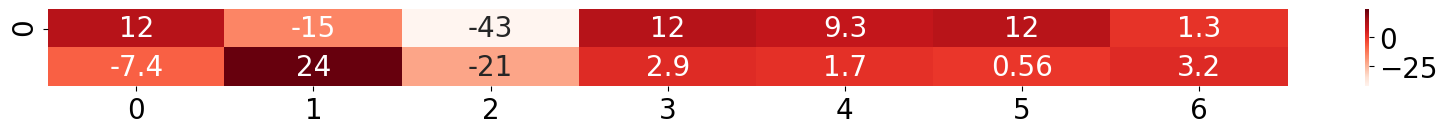

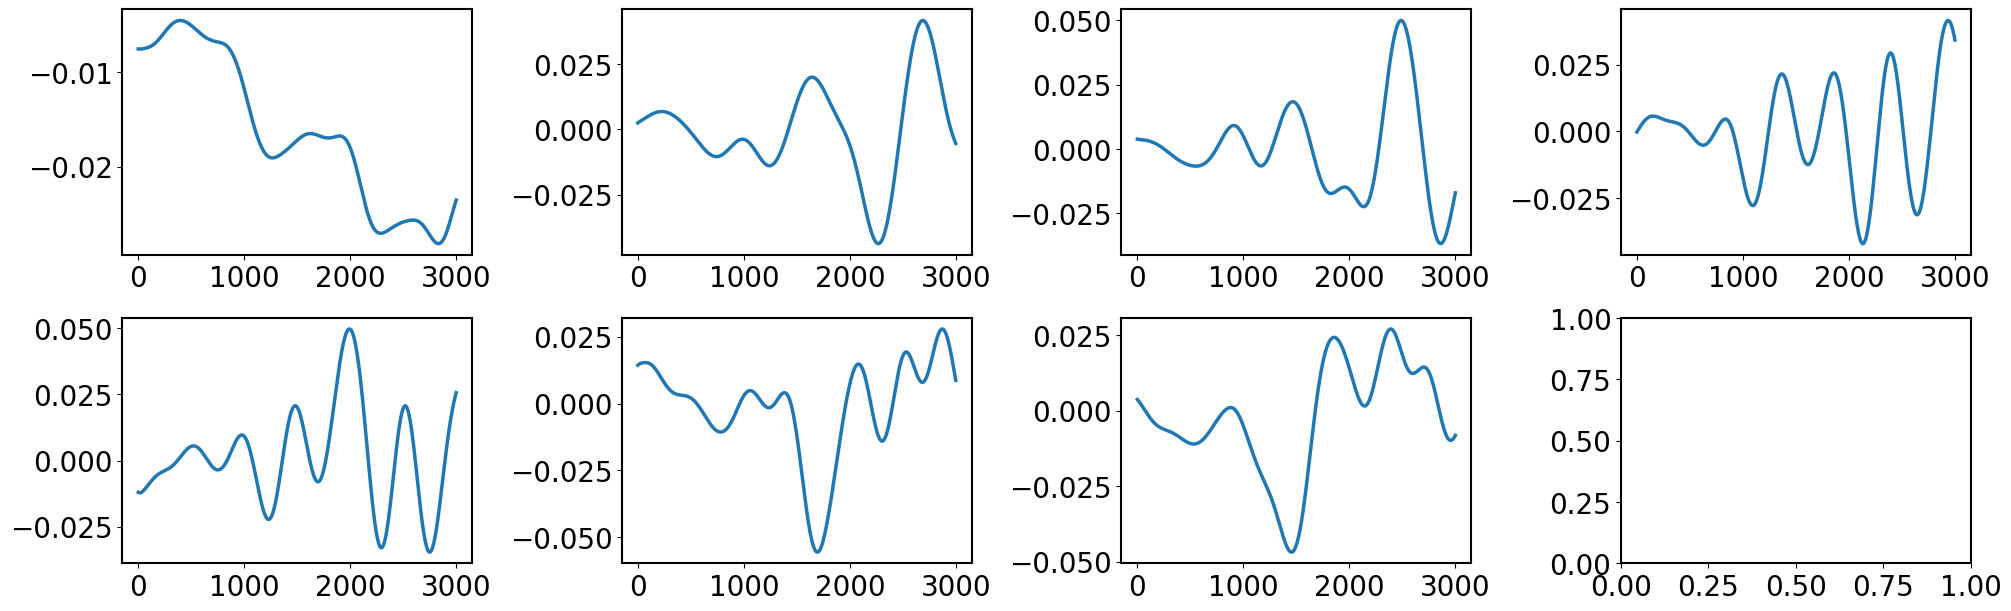

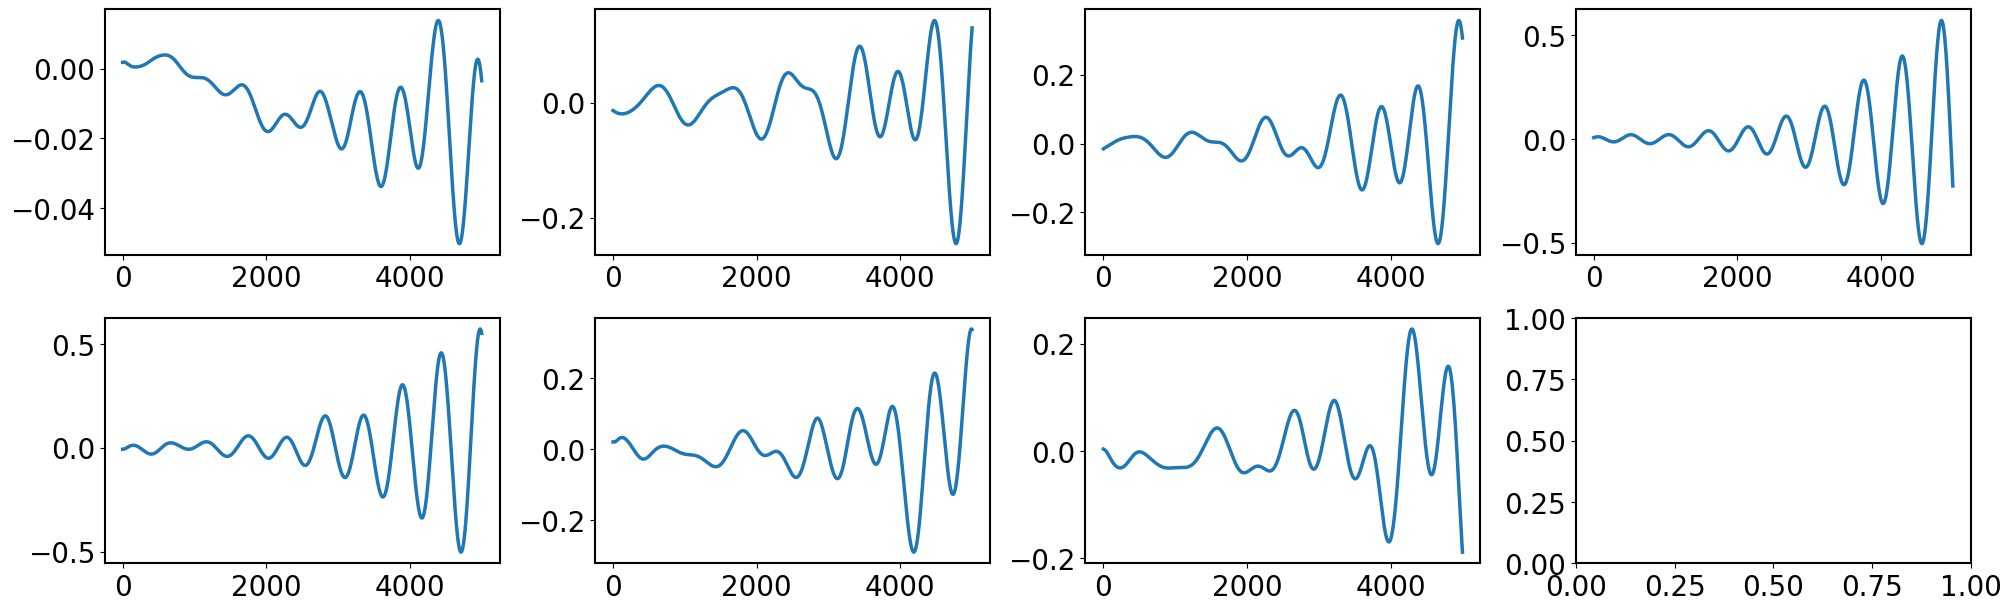

In [217]:
nb_dims = model1.Y.shape[0]

fig1 = plt.figure(figsize=(20,1))
snb.heatmap(model1.C,cmap='Reds',annot=True)

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(nb_dims//4+1, 4, 
                       constrained_layout = True, figsize=(20,3*(nb_dims//4+1)))

j = -1
for i in range(nb_dims):
    if i%4 == 0: j +=1
    ax[j,i%4].plot(model1.Y[i,:])
    
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(nb_dims//4+1, 4, 
                       constrained_layout = True, figsize=(20,3*(nb_dims//4+1)))

j = -1
for i in range(nb_dims):
    if i%4 == 0: j +=1
    ax[j,i%4].plot(model1.Y_traj[i,:])